In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# GNN - One Layer Model

Here, I train a basic GNN with NAICS links, doing a one-hop model. Batching is used for training, and nodes are sampled at each layer. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np

In [31]:
from pathlib import Path
import importlib
import pickle, re

In [4]:
import stellargraph as sg
from stellargraph.layer import HinSAGE
from stellargraph.mapper import HinSAGENodeGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import keras
import tensorflow.keras.metrics as km
from keras import initializers
import tensorflow as tf

2024-01-17 21:42:54.660713: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-17 21:42:54.660736: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-17 21:42:54.660742: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-17 21:42:54.660776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 21:42:54.660792: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Import Data
Import Stellargraph dataset for training

##### Heterogeneous graph

In [5]:
# Training and validation clients - monitor training on val clients
with open(Path(setup.temp_path).joinpath('20_DATA_stellargraph_train_val.pkl'), 'rb') as fin:
      sba_graph  = pickle.load(fin)

In [6]:
print(sba_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 551635, Edges: 53101575

 Node types:
  LoanNr_ChkDgt: [551635]
    Features: float32 vector, length 10
    Edge types: LoanNr_ChkDgt-naics->LoanNr_ChkDgt, LoanNr_ChkDgt-sector->LoanNr_ChkDgt

 Edge types:
    LoanNr_ChkDgt-sector->LoanNr_ChkDgt: [27532592]
        Weights: all 1 (default)
        Features: none
    LoanNr_ChkDgt-naics->LoanNr_ChkDgt: [25568983]
        Weights: all 1 (default)
        Features: none


##### Labels

In [7]:
label_data = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_label_info.parquet')).sort_index()

## Process labels
Get separate train, test label dataframes.  Also get initial target rate (for metric tracking)

In [8]:
train_labels = label_data[(label_data['dset'] == 'train')] \
    .drop(columns=['dset'])
val_labels = label_data[label_data['dset'] == 'val'].drop(columns=['dset'])
print(f'this graph labels shape {label_data.shape}')
print(f'train labels shape {train_labels.shape}')
print(f'validation labels shape {val_labels.shape}')

this graph labels shape (688081, 3)
train labels shape (425594, 2)
validation labels shape (126041, 2)


In [9]:
vc = train_labels['target'].value_counts(normalize=True)
base_thresh = vc.loc[1]
print(f'target rate: {base_thresh}')

target rate: 0.20307382152943884


## Train

##### Set seeds to setup

In [10]:
# Set some seeds
np.random.seed(16)
tf.random.set_seed(16)
sg.random.set_seed(4345)

##### Node Predictor Generator and "Flows"
Create objects to train on train cases, monitor on validation cases

In [11]:
generator = HinSAGENodeGenerator(sba_graph, batch_size=setup.gnn_batch_size, 
                                 num_samples=[setup.gnn_num_samples[0]],
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=2454)

In [12]:
train_gen = generator.flow(train_labels.index, train_labels['target'], shuffle=True)

In [13]:
val_gen = generator.flow(val_labels.index, val_labels['target'], shuffle=False)

##### Create HinSage model (a Keras model)

In [14]:
graphsage_model = HinSAGE(
    layer_sizes=[setup.gnn_layer_sizes[0]], 
    activations=[setup.gnn_activations[0]],
    generator=generator, bias=True, dropout=setup.gnn_dropout
)

In [15]:
x_inp, x_out = graphsage_model.in_out_tensors()

prediction = layers.Dense(units=1, activation="sigmoid",
                         kernel_initializer=initializers.glorot_uniform(seed=2343),
                         bias_initializer = initializers.Zeros())(x_out) 

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [16]:
model = Model(inputs=x_inp, outputs=prediction)
optimizer = setup.gnn_optimizer(learning_rate=setup.gnn_learning_rate)
model.compile(
    optimizer=optimizer,
    loss = losses.binary_crossentropy,  
    metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')],
)

##### Fit model

In [17]:
history = model.fit(
    train_gen, epochs=setup.gnn_epochs, validation_data=val_gen, verbose=2, shuffle=False
)

Epoch 1/20


2024-01-17 21:45:26.656496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-17 21:49:14.477582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 - 276s - loss: 0.4840 - auc: 0.2831 - auc_1: 0.6396 - val_loss: 0.4710 - val_auc: 0.3209 - val_auc_1: 0.6881 - 276s/epoch - 21ms/step
Epoch 2/20
13300/13300 - 271s - loss: 0.4805 - auc: 0.2908 - auc_1: 0.6490 - val_loss: 0.4699 - val_auc: 0.3238 - val_auc_1: 0.6891 - 271s/epoch - 20ms/step
Epoch 3/20
13300/13300 - 270s - loss: 0.4798 - auc: 0.2927 - auc_1: 0.6518 - val_loss: 0.4680 - val_auc: 0.3258 - val_auc_1: 0.6919 - 270s/epoch - 20ms/step
Epoch 4/20
13300/13300 - 268s - loss: 0.4794 - auc: 0.2939 - auc_1: 0.6523 - val_loss: 0.4681 - val_auc: 0.3284 - val_auc_1: 0.6928 - 268s/epoch - 20ms/step
Epoch 5/20
13300/13300 - 268s - loss: 0.4793 - auc: 0.2938 - auc_1: 0.6527 - val_loss: 0.4684 - val_auc: 0.3284 - val_auc_1: 0.6928 - 268s/epoch - 20ms/step
Epoch 6/20
13300/13300 - 268s - loss: 0.4788 - auc: 0.2957 - auc_1: 0.6546 - val_loss: 0.4677 - val_auc: 0.3312 - val_auc_1: 0.6949 - 268s/epoch - 20ms/step
Epoch 7/20
13300/13300 - 198s - loss: 0.4784 - auc: 0.2977 - auc_1: 0

In [18]:
# Tensorflow save format to work around issue 
# https://github.com/tensorflow/tensorflow/issues/46659
model.save(Path(setup.temp_path).joinpath('21_DATA_model.keras'), save_format='tf')

## History Plots

In [19]:
this_history_df = pd.DataFrame(history.history)

In [32]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [21]:
this_history_df.columns

Index(['loss', 'auc', 'auc_1', 'val_loss', 'val_auc', 'val_auc_1'], dtype='object')

In [34]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('21_REPORT_fit_history.csv'))

<Axes: >

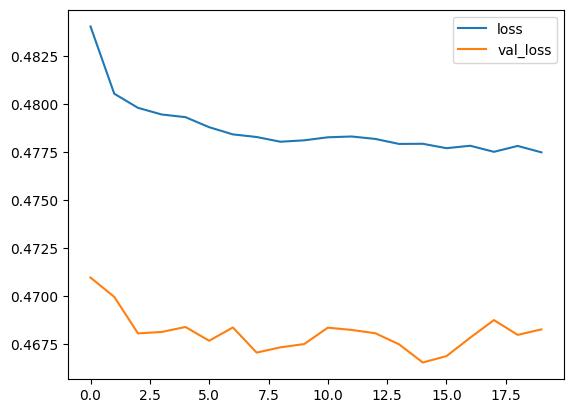

In [35]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

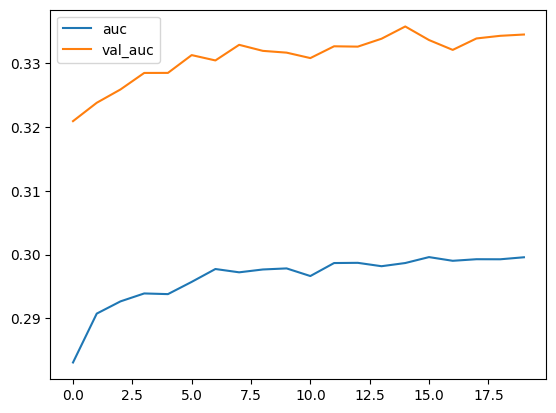

In [36]:
this_history_df[['auc', 'val_auc']].plot()

## Metrics
Get basic metrics for the fitting graph.  Final metrics will be obtained on a graph containing the test nodes later

In [38]:
val_metrics = model.evaluate(val_gen)

3939/3939 [==============================] - 52s 13ms/step - loss: 0.4684 - auc: 0.3343 - auc_1: 0.6948


In [39]:
train_metrics = model.evaluate(train_gen)

13300/13300 [==============================] - 173s 13ms/step - loss: 0.4663 - auc: 0.3314 - auc_1: 0.6929


In [40]:
metrics = pd.concat([pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in val_metrics]))),
                         pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in train_metrics])))],
                        keys=['val', 'train'])
metrics.to_csv(Path(setup.temp_path).joinpath('21_REPORT_train_metrics.csv'), index=True)
metrics

,,loss,auc,auc_1
val,0,0.468446,0.334268,0.694827
train,0,0.466289,0.331405,0.692876


In [41]:
TO DO:
    last prediction layer, Item 15 - change initializers?
    note started 9 pm
    next perf script
    
- 2 hop GNN
- Investigate isolated NAICS performance in test set, plot NAICS decile count plot

SyntaxError: invalid syntax (1224532821.py, line 1)